# Importing libraries

In [1]:
from pprint import PrettyPrinter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import transformers
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from lightgbm import LGBMClassifier
from sklearn.base import BaseEstimator
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    PrecisionRecallDisplay,
    RocCurveDisplay,
    classification_report,
    f1_score,
    roc_auc_score,
)
from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from tqdm import notebook
from transformers import logging
from xgboost import XGBClassifier

RANDOM_STATE = 12345
N_ITER = 5
CV_FOLDS = 2
DATA_SIZE = 1000
MAX_LENGTH = 512
F1_SCORE_THRESHOLD = 0.75
ROC_AUC_THRESHOLD = 0.5
TRAIN_SET_SIZE = 0.75
ENABLE_PARALLELIZATION = False
SCORER = "f1"
BATCH_SIZE = 10

In [2]:
# Using all processors
N_JOBS = -1 if ENABLE_PARALLELIZATION else None

# Visual theme for plots
sns.set_theme()

# Ignoring warnings when defining a pretrained transformers model
logging.set_verbosity_error()

# Defining a cross-validator
KF = KFold(n_splits=CV_FOLDS, random_state=RANDOM_STATE, shuffle=True)

# Setting printing behavior
pp = PrettyPrinter(depth=4)

In [3]:
# Determining the device used
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: {}".format(device))

# Printing details of GPU device (if present)
if device.type == "cuda":
    gpu_device_name = torch.cuda.get_device_name(0)
    gpu_memory_alloc_GB = torch.cuda.memory_allocated(0) / 1024**3
    gpu_memory_cached_GB = torch.cuda.memory_reserved(0) / 1024**3

    print(f"Device name: {gpu_device_name}")
    print(f"Memory allocated: {np.round(gpu_memory_alloc_GB, 1)} GB")
    print(f"Memory cached: {np.round(gpu_memory_cached_GB, 1)} GB")

Using device: cpu


**Summary**

In this small section, we have collected all the libraries and utilities that we will use during the process of completing the project. In particular, we defined a number of constants to achieve code flexibility, imported a number of libraries for gradient boosting and machine learning as well as transformers, and also added the opportunity to execute the code on *GPU*.

# Uploading data

In [4]:
# Loading data to a DataFrame
toxic_comments_df = pd.read_csv(
    "datasets/toxic_comments.csv", usecols=["text", "toxic"], header=0
)

# Displaying random 5 rows
toxic_comments_df.sample(5, random_state=RANDOM_STATE)

,text,toxic
109486,Expert Categorizers \n\nWhy is there no menti...,0
104980,"""\n\n Noise \n\nfart* talk. """,1
82166,"An indefinite block is appropriate, even for a...",0
18721,I don't understand why we have a screenshot of...,0
128178,"Hello! Some of the people, places or things yo...",0


We can see that the data we have uploaded contains the following information.

<table>
<thead>
<tr><th>Column</th><th>Description</th></tr>
</thead>
<tbody>
    <tr><td><code>text</code></td><td><i>Text of a commentary</i></td></tr>
<tr><td><code>toxic</code></td><td><i>Indicator of the toxicity of a commentary</i></td></tr>
</tbody>
</table>

We observe that the data consists of some comments, which are assigned toxicity values of zero (positive comment) or one (negative comment). Let's display more detailed information about the data.

In [5]:
toxic_comments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


**Summary**

At this stage, we were able to study the data that was provided to us, as a result of which we found out that the objects in the dataset represent texts of commentaries along with a binary indicator of its toxicity. Furthermore, there are no missing values in the data.

# Data preparation

## Class balance and sampling

Since the task we are going to solve here is classification, let's first look at the balance of classes.

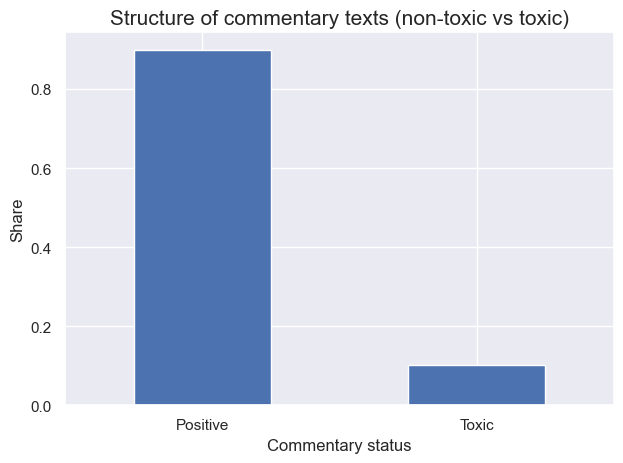

Positive    0.898
Toxic       0.102
Name: toxic, dtype: float64

In [6]:
# Plotting the structure of the target
toxic_comments_df["toxic"].value_counts(normalize=True).plot(
    kind="bar",
    xlabel="Commentary status",
    ylabel="Share",
)
plt.xticks(ticks=[0, 1], labels=["Positive", "Toxic"], rotation=0)
plt.title("Structure of commentary texts (non-toxic vs toxic)", fontsize=15)
plt.tight_layout()
plt.show()

# Displaying the shares of classes
toxicity_struct_num = toxic_comments_df["toxic"].value_counts(normalize=True)
toxicity_struct_num.index = ["Positive", "Toxic"]
display(toxicity_struct_num.round(3))

We notice quite a strong class imbalance that may lead to poor learning performance. We will deal with this problem later. For now, the next step is to tokenize data and then use the tokenized data to create embeddings. However, it will be extremely time-consuming and computationally expensive to preprocess all 159,292 commentaries. Hence, let's choose a subset of them. 

In [7]:
# Choosing a number of random objects
toxic_df = toxic_comments_df.sample(DATA_SIZE, random_state=RANDOM_STATE).reset_index(
    drop=True
)

# Displaying information about the subset of data chosen
toxic_num = toxic_df["toxic"].value_counts()
toxic_num.name = "comment_num"

toxic_share = toxic_df["toxic"].value_counts(normalize=True)
toxic_share.name = "comment_share"

toxic_balance = pd.concat([toxic_num, toxic_share], axis=1)
display(toxic_balance)

,comment_num,comment_share
0,890,0.89
1,110,0.11


We chose 1000 randomly sampled observations and see that the balance of classes stayed approximately the same.

## Encoding

### Tokenization

In [8]:
%%time

# Defining a tokenizer
tokenizer = transformers.AutoTokenizer.from_pretrained("unitary/toxic-bert")

# Tokenizing data
data_tokenized = toxic_df["text"].apply(
    lambda x: tokenizer.encode(
        x,
        add_special_tokens=True,
        max_length=MAX_LENGTH,
        truncation=True,
        padding="max_length",
    )
)

# Type conversion
data_padded = np.array([i for i in data_tokenized.values])

# Creating attention mask
attention_mask = np.where(data_padded != 0, 1, 0)

CPU times: total: 6.94 s
Wall time: 11.8 s


In [9]:
print(f"Tokenized (padded) data dimensions: {data_padded.shape}")
print(f"Attention mask dimensions: {attention_mask.shape}")

Tokenized (padded) data dimensions: (1000, 512)
Attention mask dimensions: (1000, 512)


We see that we got the desired dimensions of the matrices for tokenized data and attention mask. 

### Features extraction (embeddings)

The next logical step is to recover the features from the tokenized data (embeddings). Firstly, let's load the model from `unitary/toxic-bert` and add `to(device)` in order to allow for using *GPU*.

**Warning:** *Loading the model in the following cell may take approximately <u>8 minutes</u> on CPU.*

In [10]:
%%time

# Loading the model ("toxic-bert")
model = transformers.AutoModel.from_pretrained("unitary/toxic-bert").to(device)

CPU times: total: 2.11 s
Wall time: 2.64 s


Next, we launch the process of creating embeddings in batches which can also be executed on *GPU*.

**Warning:** *The embedding creation process in the following cell may take approximately <u>40 minutes</u> to run on CPU.*

In [11]:
%%time

# Setting batch size
batch_size = BATCH_SIZE

# Preallocating an empty list to store embeddings
embeddings = []

# Launching features extraction algorithm (retrieving embeddings)
for i in notebook.tqdm(range(data_padded.shape[0] // batch_size)):
    
    # Transforming batch data into Tensor
    batch = torch.LongTensor(data_padded[batch_size * i : batch_size * (i + 1)]).to(device)
    
    # Transforming attention mask into Tensor
    attention_mask_batch = torch.LongTensor(
        attention_mask[batch_size * i : batch_size * (i + 1)]
    ).to(device)
    
    # Retrieving embeddings (without training BERT)
    with torch.no_grad():
        
        # Passing batch data and mask to the model
        batch_embeddings = model(batch, attention_mask=attention_mask_batch)
    
    # Retrieving the appropriate elements and adding to other embeddings
    embeddings.append(batch_embeddings[0][:, 0, :].cpu().numpy())

  0%|          | 0/100 [00:00<?, ?it/s]

CPU times: total: 2h 50min 55s
Wall time: 43min 18s


In [12]:
print(f"Batch size: {batch_size}")
print(f"Number of batches: {len(embeddings)}")
print(f"Emdeddings dimensions per batch: {embeddings[0].shape}")
print(f"Number of objects in data: {data_padded.shape[0]}")

Batch size: 10
Number of batches: 100
Emdeddings dimensions per batch: (10, 768)
Number of objects in data: 1000


### Data split

Now we can just concatenate all embeddings into one features matrix.

In [13]:
# Joining the embeddings together into a feature matrix
features = np.concatenate(embeddings)

# Defining target
target = toxic_df["toxic"]

print(f"Features matrix dimensions: {features.shape}")
print(f"Target vector length: {target.shape}")

Features matrix dimensions: (1000, 768)
Target vector length: (1000,)


We then split the data into training and test set, at the same time preserving the proportions of classes in `target` by using `stratify=target`.

In [14]:
target.value_counts(normalize=True)

0    0.89
1    0.11
Name: toxic, dtype: float64

In [15]:
# Splitting the data into training and test sets
features_train, features_test, target_train, target_test = train_test_split(
    features, target, train_size=TRAIN_SET_SIZE, random_state=RANDOM_STATE, stratify=target
)

print(f"Features matrix dimensions (train): {features_train.shape}")
print(f"Target vector length (train): {target_train.shape}\n")
print(f"Features matrix dimensions (test): {features_test.shape}")
print(f"Target vector length (test): {target_test.shape}")

Features matrix dimensions (train): (750, 768)
Target vector length (train): (750,)

Features matrix dimensions (test): (250, 768)
Target vector length (test): (250,)


In [16]:
target.value_counts(normalize=True)

0    0.89
1    0.11
Name: toxic, dtype: float64

In [17]:
target_train.value_counts(normalize=True)

0    0.889333
1    0.110667
Name: toxic, dtype: float64

In [18]:
target_test.value_counts(normalize=True)

0    0.892
1    0.108
Name: toxic, dtype: float64

Later, in addition to usual models, we will use `AutoModelForSequenceClassification` for which it suffices to just provide the original text of a commentary. Hence, we should also split the data here, preserving only the test set.

In [19]:
features_text = toxic_df["text"]
_, test_text, _, _ = train_test_split(
    features_text,
    target,
    train_size=TRAIN_SET_SIZE,
    random_state=RANDOM_STATE,
    stratify=target,
)

**Summary**

This stage was aimed at encoding the dataset with commentaries in order to enable models to make predictions. The data has been tokenized which was later used for features extraction using embeddings. Lastly, we split the data.

# Hyperparameter tuning

## Preparation for tuning

Now, we can start preparing for hyperparameter tuning. Here, we will write a function called `prepare_tuning()` where we can pass the model as well as some keyword parameters signifying what hyperparameters and what values we would like to consider in the grid search.

In [20]:
def prepare_tuning(model, **tuning_params):
    """Makes preparations for grid search.

    Creates an Imbalanced-Learn Pipeline using
    SMOTE and model as steps. Additionally, creates
    a parameter grid as a dict with keys names prefixed
    by the alias of the last estimator in the Pipeline created.

    Parameters
    ----------
    model : BaseEstimator
        Class implementing estimators from Scikit-Learn or
        Gradient Boosting libraries. Intended to be the last
        estimator in the pipeline.
    **tuning_params
        Keyword arguments used to create a grid of hyperparameters.

    Returns
    -------
    BaseEstimator, dict
        Pipeline object and hyperparameter grid mapping hyperparameter
        names to the values to consider in grid search.
    """
    # Creating Imblearn's Pipeline
    upsampler = SMOTE(random_state=RANDOM_STATE)
    pipeline = make_imb_pipeline(upsampler, model)

    # Retrieving the last estimator name from pipeline
    pipeline_steps = pipeline.named_steps
    pipeline_steps_names = list(pipeline_steps.keys())
    last_estimator_name = pipeline_steps_names[-1]

    # Creating a parameter grid with alias-prefixed keys
    grid = {
        last_estimator_name + "__" + param: tuning_params[param]
        for param in tuning_params
    }

    return pipeline, grid

## Grid search

We will consider 3 machine learning models and 3 gradient boosting models. In addition, we will experiment with the transformer for direct text classification. Hence, the following models will be considered:

1. `DecisionTreeClassifier`
2. `RandomForestClassifier`
3. `KNeighborsClassifier`
4. `CatBoostClassifier`
5. `XGBClassifier`
6. `LGBMClassifier`
7. `AutoModelForSequenceClassification`

### `DecisionTree`

In [21]:
# Defining Decision tree
dt_model = DecisionTreeClassifier(random_state=RANDOM_STATE)

# Creating the pipeline and hyperparameter grid
dt_pipeline, dt_grid = prepare_tuning(
    model=dt_model,
    max_depth=np.arange(1, 10),
    criterion=["gini", "entropy", "log_loss"],
)
pp.pprint(dt_grid)

{'decisiontreeclassifier__criterion': ['gini', 'entropy', 'log_loss'],
 'decisiontreeclassifier__max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9])}


In [22]:
%%time

# Instantiating RSCV object
dt_grid_search = RandomizedSearchCV(
    estimator=dt_pipeline,
    param_distributions=dt_grid,
    random_state=RANDOM_STATE,
    cv=KF,
    n_iter=N_ITER,
    scoring=SCORER,
    n_jobs=N_JOBS,
)

# Launching grid search
dt_grid_search.fit(features_train, target_train)

# Displaying the best score
print("F1-score (Decision tree) = {:.2f}".format(dt_grid_search.best_score_))

F1-score (Decision tree) = 0.89
CPU times: total: 7.83 s
Wall time: 7.56 s


In [23]:
# Displaying the best hyperparameters
display(dt_grid_search.best_params_)

{'decisiontreeclassifier__max_depth': 9,
 'decisiontreeclassifier__criterion': 'gini'}

### `RandomForest`

In [24]:
# Defining Random forest
rf_model = RandomForestClassifier(random_state=RANDOM_STATE)

# Creating the pipeline and grid
rf_pipeline, rf_grid = prepare_tuning(
    model=rf_model, max_depth=np.arange(1, 5), n_estimators=np.arange(10, 100, 10)
)
pp.pprint(rf_grid)

{'randomforestclassifier__max_depth': array([1, 2, 3, 4]),
 'randomforestclassifier__n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])}


In [25]:
%%time

# Instantiating RSCV object
rf_grid_search = RandomizedSearchCV(
    estimator=rf_pipeline,
    param_distributions=rf_grid,
    random_state=RANDOM_STATE,
    cv=KF,
    n_iter=N_ITER,
    scoring=SCORER,
    n_jobs=N_JOBS,
)

# Launching grid search
rf_grid_search.fit(features_train, target_train)

# Displaying the best score
print("F1-score (Random forest) = {:.4f}".format(rf_grid_search.best_score_))

F1-score (Random forest) = 0.9424
CPU times: total: 11 s
Wall time: 10.9 s


In [26]:
# Displaying the best hyperparameters
display(rf_grid_search.best_params_)

{'randomforestclassifier__n_estimators': 80,
 'randomforestclassifier__max_depth': 3}

### `KNN`

In [27]:
# Defining KNN
knn_model = KNeighborsClassifier()

# Creating the pipeline and grid
knn_pipeline, knn_grid = prepare_tuning(
    model=knn_model, n_neighbors=np.arange(2, 9), weights=["uniform", "distance"]
)
pp.pprint(knn_grid)

{'kneighborsclassifier__n_neighbors': array([2, 3, 4, 5, 6, 7, 8]),
 'kneighborsclassifier__weights': ['uniform', 'distance']}


In [28]:
%%time

# Instantiating RSCV object
knn_grid_search = RandomizedSearchCV(
    estimator=knn_pipeline,
    param_distributions=knn_grid,
    random_state=RANDOM_STATE,
    cv=KF,
    n_iter=N_ITER,
    scoring=SCORER,
    n_jobs=N_JOBS,
)

# Launching grid search
knn_grid_search.fit(features_train, target_train)

# Displaying the best score
print("F1-score (KNN) = {:.4f}".format(knn_grid_search.best_score_))

F1-score (KNN) = 0.9177
CPU times: total: 1.72 s
Wall time: 697 ms


In [29]:
# Displaying the best hyperparameters
display(knn_grid_search.best_params_)

{'kneighborsclassifier__weights': 'uniform',
 'kneighborsclassifier__n_neighbors': 2}

### `CatBoost`

In [30]:
# Defining Catboost
cb_model = CatBoostClassifier(verbose=0)

# Creating the pipeline and grid
cb_pipeline, cb_grid = prepare_tuning(
    model=cb_model,
    max_depth=np.arange(1, 5),
    n_estimators=np.arange(10, 100, 10),
    learning_rate=np.arange(0.1, 1.0, 0.1),
)
pp.pprint(cb_grid)

{'catboostclassifier__learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 'catboostclassifier__max_depth': array([1, 2, 3, 4]),
 'catboostclassifier__n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])}


In [31]:
%%time

# Instantiating RSCV object
cb_grid_search = RandomizedSearchCV(
    estimator=cb_pipeline,
    param_distributions=cb_grid,
    random_state=RANDOM_STATE,
    cv=KF,
    n_iter=N_ITER,
    scoring=SCORER,
    n_jobs=N_JOBS,
)

# Launching grid search
cb_grid_search.fit(features_train, target_train)

# Displaying the best score
print("F1-score (Catboost) = {:.4f}".format(cb_grid_search.best_score_))

F1-score (Catboost) = 0.9284
CPU times: total: 1min 20s
Wall time: 13.6 s


In [32]:
# Displaying the best hyperparameters
display(cb_grid_search.best_params_)

{'catboostclassifier__n_estimators': 40,
 'catboostclassifier__max_depth': 1,
 'catboostclassifier__learning_rate': 0.6}

### `XGBoost`

In [33]:
# Defining XGBoost
xgb_model = XGBClassifier()

# Creating the pipeline and grid
xgb_pipeline, xgb_grid = prepare_tuning(
    model=xgb_model,
    max_depth=np.arange(1, 5),
    n_estimators=np.arange(10, 100, 10),
    learning_rate=np.arange(0.1, 1.0, 0.1),
)
pp.pprint(xgb_grid)

{'xgbclassifier__learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 'xgbclassifier__max_depth': array([1, 2, 3, 4]),
 'xgbclassifier__n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])}


In [34]:
%%time

# Instantiating RSCV object
xgb_grid_search = RandomizedSearchCV(
    estimator=xgb_pipeline,
    param_distributions=xgb_grid,
    random_state=RANDOM_STATE,
    cv=KF,
    n_iter=N_ITER,
    scoring=SCORER,
    n_jobs=N_JOBS,
)

# Launching grid search
xgb_grid_search.fit(features_train, target_train)

# Displaying the best score
print("F1-score (XGBoost) = {:.4f}".format(xgb_grid_search.best_score_))

F1-score (XGBoost) = 0.9259
CPU times: total: 33 s
Wall time: 4.63 s


In [35]:
# Displaying the best hyperparameters
display(xgb_grid_search.best_params_)

{'xgbclassifier__n_estimators': 40,
 'xgbclassifier__max_depth': 3,
 'xgbclassifier__learning_rate': 0.5}

### `LightGBM`

In [36]:
# Defining LightGBM
lgbm_model = LGBMClassifier()

# Creating the pipeline and grid
lgbm_pipeline, lgbm_grid = prepare_tuning(
    model=lgbm_model,
    max_depth=np.arange(1, 6),
    n_estimators=np.arange(10, 100, 10),
    learning_rate=np.arange(0.1, 1.0, 0.1),
)
pp.pprint(lgbm_grid)

{'lgbmclassifier__learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 'lgbmclassifier__max_depth': array([1, 2, 3, 4, 5]),
 'lgbmclassifier__n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])}


In [37]:
%%time

# Instantiating RSCV object
lgbm_grid_search = RandomizedSearchCV(
    estimator=lgbm_pipeline,
    param_distributions=lgbm_grid,
    random_state=RANDOM_STATE,
    cv=KF,
    n_iter=N_ITER,
    scoring=SCORER,
    n_jobs=N_JOBS,
)

# Launching grid search
lgbm_grid_search.fit(features_train, target_train)

# Displaying the best score
print("F1-score (LightGBM) = {:.4f}".format(lgbm_grid_search.best_score_))

F1-score (LightGBM) = 0.8970
CPU times: total: 30.7 s
Wall time: 4.4 s


In [38]:
# Displaying the best hyperparameters
display(xgb_grid_search.best_params_)

{'xgbclassifier__n_estimators': 40,
 'xgbclassifier__max_depth': 3,
 'xgbclassifier__learning_rate': 0.5}

### `SequenceClassification`

In [39]:
%%time

# Defining the model name to load
model_path = "martin-ha/toxic-comment-model"

# Instantiating a tokenizer object
tokenizer = transformers.AutoTokenizer.from_pretrained(model_path)

# Defining the model for sequence classification
model = transformers.AutoModelForSequenceClassification.from_pretrained(model_path)

# Instantiating pipeline for text classification
text_pipeline = transformers.TextClassificationPipeline(
    model=model, tokenizer=tokenizer
)

# Lauching sequence classification algorithm
predictions_text = []
for text in notebook.tqdm(test_text):
    prediction_text = text_pipeline(text[:MAX_LENGTH])
    predictions_text.append(1 if prediction_text[0]["label"] == "toxic" else 0)

# Computing test F1-score
text_classification_f1_score = f1_score(y_true=target_test, y_pred=predictions_text)

print("F1-score (Sequence classification) = {:.4f}".format(text_classification_f1_score))

  0%|          | 0/250 [00:00<?, ?it/s]

F1-score (Sequence classification) = 0.8571
CPU times: total: 1min 45s
Wall time: 30.9 s


**Summary**

In this section, we have trained a number of different models with different hyperparameters.

# Models analysis

In [40]:
def plot_model_comparison(
    results,
    metric_name="metric_name",
    title_name="title_name",
    dot_size=150,
    figure_dims=(15, 7),
    xticks_fontsize=15,
    yticks_fontsize=12,
    title_fontsize=20,
    ylabel_fontsize=15,
):
    """Provides models performance visualization.

    Generates a scatterplot with model names and their
    respective metric values for comparison.

    Parameters
    ----------
    results : list of tuples
        Sequence of tuples with model names and metric values.
    metric_name : str, default="metric_name"
        Name of the metric.
    title_name : str, default="title_name"
        Title of the plot.
    dot_size : int, default=150
        Size of scatterplot dots.
    figure_dims : tuple of integers, default=(15, 7)
        Dimensions of the figure.
    xticks_fontsize : int, default=15
        Size of xticks on the plot.
    yticks_fontsize : int, default=12
        Size of yticks on the plot.
    title_fontsize : int, default=20
        Size of the title of the plot.
    ylabel_fontsize : int, default=15
        Size of the Y-label.
    """
    # Separating scores from a sequence of tuples passed
    _, scores = zip(*results)
    # Joining model names with scores
    names_with_scores = [f"{name}\n{loss:.4f}" for name, loss in results]

    # Making a plot
    plt.figure(figsize=figure_dims)

    plt.scatter(range(len(results)), scores, s=dot_size)

    plt.xticks(range(len(results)), names_with_scores, fontsize=xticks_fontsize)
    plt.yticks(fontsize=yticks_fontsize)
    plt.ylabel(metric_name, fontsize=ylabel_fontsize)
    plt.title(title_name, fontsize=title_fontsize)

    plt.tight_layout()
    plt.show()

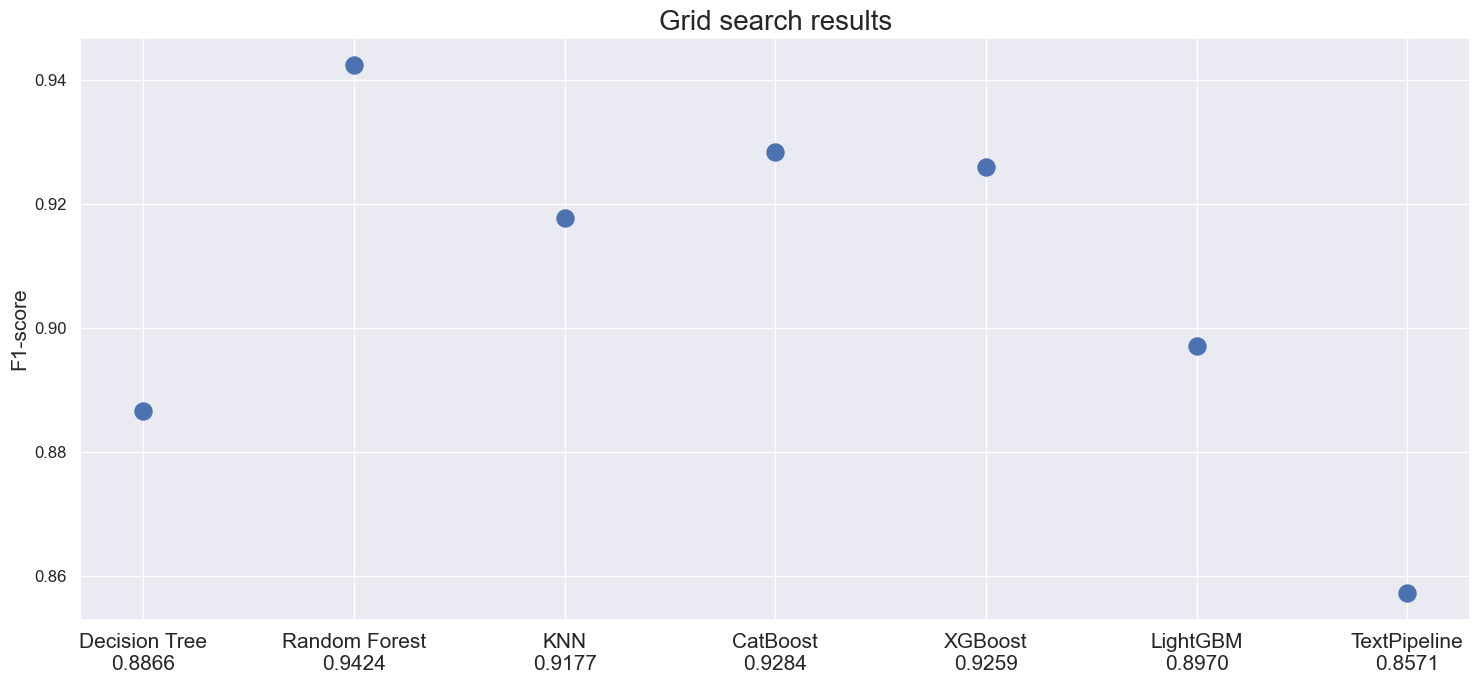

In [41]:
# Defining the results of grid search
results = [
    ("Decision Tree", dt_grid_search.best_score_),
    ("Random Forest", rf_grid_search.best_score_),
    ("KNN", knn_grid_search.best_score_),
    ("CatBoost", cb_grid_search.best_score_),
    ("XGBoost", xgb_grid_search.best_score_),
    ("LightGBM", lgbm_grid_search.best_score_),
    ("TextPipeline", text_classification_f1_score),
]

# Vizualizing the results of grid search
plot_model_comparison(
    results,
    metric_name="F1-score",
    title_name="Grid search results",
)

In [42]:
# Selecting the optimal model
final_model = rf_grid_search.best_estimator_

In [43]:
# Displaying the best settings
display(rf_grid_search.best_params_)

{'randomforestclassifier__n_estimators': 80,
 'randomforestclassifier__max_depth': 3}

# Quality and sanity check

In [44]:
# Computing F1-score on test set
predictions_test = final_model.predict(features_test)
final_model_f1_score = f1_score(y_true=target_test, y_pred=predictions_test)

# Computing AUC-ROC
class_probs = final_model.predict_proba(features_test)
pos_class_probs = class_probs[:, 1]
final_model_roc_auc = roc_auc_score(y_true=target_test, y_score=pos_class_probs)

# Fitting dummy model
dummy_model = DummyClassifier(strategy="constant", constant=1)
dummy_model.fit(features_train, target_train)
dummy_predictions = dummy_model.predict(features_test)
dummy_model_f1_score = f1_score(y_true=target_test, y_pred=dummy_predictions)

# Quality check
assert (
    final_model_f1_score >= F1_SCORE_THRESHOLD
), "The model performance is unsatisfactory"
print("QUALITY CHECK: PASSED")
print("F1-score (test) = {:.4f}\n".format(final_model_f1_score))

# Sanity check
assert (final_model_roc_auc > ROC_AUC_THRESHOLD) & (
    final_model_f1_score > dummy_model_f1_score
), "The model is inadequate"
print("SANITY CHECK: PASSED")
print("AUC-ROC = {:.4f}".format(final_model_roc_auc))

QUALITY CHECK: PASSED
F1-score (test) = 0.9630

SANITY CHECK: PASSED
AUC-ROC = 0.9965


# Final model analysis

## Classification statistics

In [45]:
# Names of classes to be printed in the report
target_names = ["positive", "toxic"]

# Printing the classification metrics table
print(
    classification_report(
        y_true=target_test, y_pred=predictions_test, target_names=target_names
    )
)

              precision    recall  f1-score   support

    positive       1.00      1.00      1.00       223
       toxic       0.96      0.96      0.96        27

    accuracy                           0.99       250
   macro avg       0.98      0.98      0.98       250
weighted avg       0.99      0.99      0.99       250



<table>
<thead>
<tr><th>Item</th><th>Description</th></tr>
</thead>
<tbody>
    <tr><td><b>Final model</b></td><td><i>Random Forest</i></td></tr>
    <tr><td><b>Hyperparameters</b></td><td><i>80 trees, depth 3</i></td></tr>
    <tr><td><b>F1-score</b></td><td><i>96%</i></td></tr>
    <tr><td><b>ROC_AUC</b></td><td><i>99.65%</i></td></tr>
    <tr><td><b>Recall</b></td><td><i>Model correctly detects 96% of all toxic commentaries</i></td></tr>
    <tr><td><b>Precision</b></td><td><i>Model correctly detected 96% of truly toxic commentaries</i></td></tr>
</tbody>
</table>

## ROC/PR curves

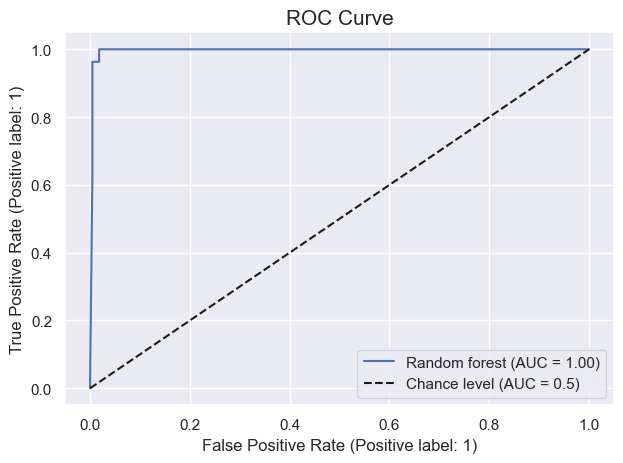

In [46]:
# Displaying ROC Curve
RocCurveDisplay.from_estimator(
    estimator=final_model,
    X=features_test,
    y=target_test,
    name="Random forest",
    plot_chance_level=True,
)
plt.title("ROC Curve", fontsize=15)
plt.tight_layout()
plt.show()

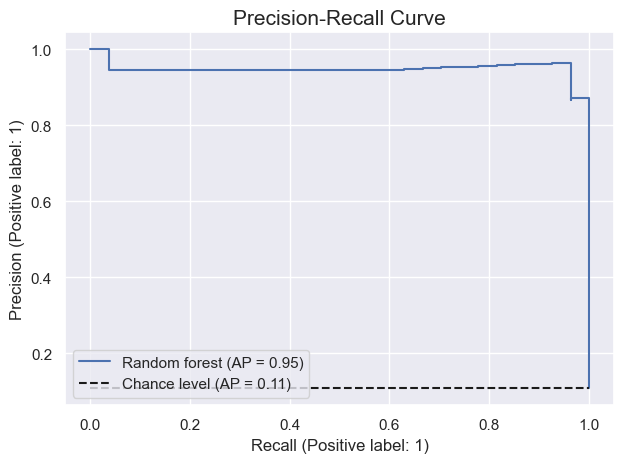

In [47]:
# Displaying Precision-Recall Curve
PrecisionRecallDisplay.from_estimator(
    estimator=final_model,
    X=features_test,
    y=target_test,
    name="Random forest",
    plot_chance_level=True,
)
plt.title("Precision-Recall Curve", fontsize=15)
plt.tight_layout()
plt.show()

## Confusion matrix

In [48]:
# Setting the default plot style
sns.reset_defaults()

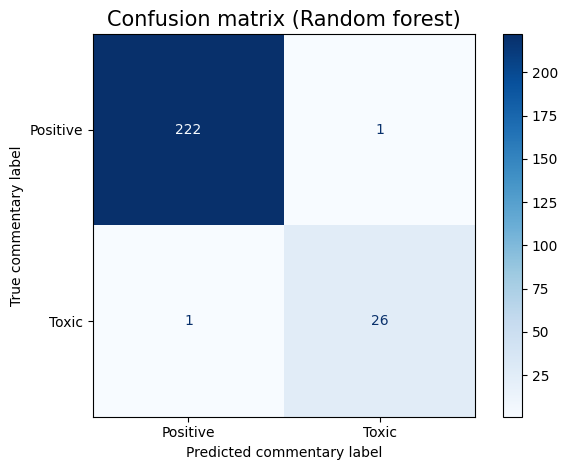

In [49]:
# Displaying Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    estimator=final_model,
    X=features_test,
    y=target_test,
    display_labels=("Positive", "Toxic"),
    cmap="Blues",
)
plt.title("Confusion matrix (Random forest)", fontsize=15)
plt.xlabel("Predicted commentary label")
plt.ylabel("True commentary label")
plt.tight_layout()
plt.show()

# Final conclusion

This project was devoted to the task of textual classification and determination of the toxicity of comments. During the execution of the project, the data was studied and encoded using embeddings. The subsequent procedure of selecting hyperparameters for a number of machine learning and gradient boosting models showed the success of the *Random Forest* model, which not only has the required quality, but is also adequate enough, which was noticeable by the high values of the *F1* and *AUC_ROC* metrics.